<h2><center>RF Pulse design</center></h2>
<h3><center>BME 639: Magnetic Resonance Imaging  
    <br> The University of Arizona, Spring 2018</center></h3>

    * Code demonstration for design of simple Sinc RF pulses and simulations of slice profiles

    * Makes use of functions from the RF pulse design MATLAB toolbox written by Dr. John Pauly, Stanford University 
    * Subset of toolbox has been ported to Python 3 and is located in the lib/ directory 


Mahesh Keerthivasan
<br>
April 14, 2018




In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [2]:
from lib.slr import *
from lib.utils import rfscaleg

### Sinc RF pulse Design

* Recall that a sinc pulse is defined in terms of its bandwidth $\Delta f$, duration $T$ and amplitude $A$. The amplitude $A$ is calculated for the desired flip angle. 

$b1(t)= \left\{
                \begin{array}{ll}
                  A sinc(\pi \Delta f (t-T/2)), if 0 \leq t \leq T/2\\
                  0, otherwise 
                \end{array}
              \right.$

* And the $sinc()$ function is defined as

$sinc(t) = \frac{sin(\pi t)}{\pi t}$


#### Design a sinc RF pulse with time-bandwidth product ($T * \Delta f$) = 12, duration 4 milliseconds and flip angle = 30 degrees.

* Start by implementing the sinc function assuming amplitude $A = 1$. Then scale the RF pulse to the desired flip angle. 

* Assume the RF pulse has 256 points



In [3]:
N = 256 #Number of samples in RF pulse
T = 4 # Duration in msec
tbw = 12 #Time bandwidth
bw = tbw / T # bandwidth in kHz 
print('Bandwidth of RF pulse: ', bw, 'kHz')
A = 1 
t = np.linspace(0, T, N)
sinc = A * np.divide(np.sin(np.pi*bw*(t-T/2)),(np.pi*bw*(t-T/2)))

Bandwidth of RF pulse:  3.0 kHz


* Flip angle of RF pulse defined as the area under the envelope of B1(t)

    - Scale the RF pulse to the desired flip angle: sum of RF pulse amplitudes should be $\theta$ (radians) 

    - We could also scale the RF amplitude to Gaus

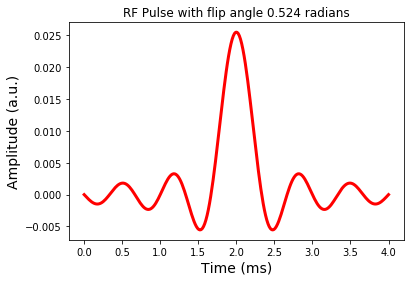

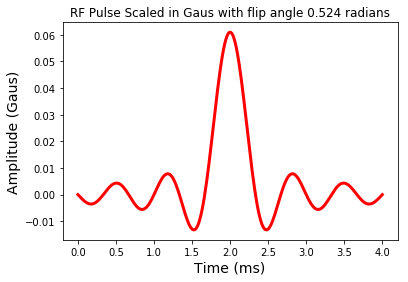

In [4]:
# Scale the RF to desired flip angle
thetaDeg = 30
theta = thetaDeg * np.pi / 180 #radians
b1 = sinc / np.sum(sinc)
b1 = b1 * theta

# Plot the RF
fig = plt.figure(); plt.plot(t,b1,'r-',linewidth=3.0)
plt.xlabel('Time (ms)',fontsize=14)
plt.ylabel('Amplitude (a.u.)',fontsize=14)
plt.title('RF Pulse with flip angle %1.3f radians' %theta)
plt.show()

# Scale RF to Gaus
b1Gaus = rfscaleg(b1,T)

# Plot the RF
fig = plt.figure(); plt.plot(t,b1Gaus,'r-',linewidth=3.0)
plt.xlabel('Time (ms)',fontsize=14)
plt.ylabel('Amplitude (Gaus)',fontsize=14)
plt.title('RF Pulse Scaled in Gaus with flip angle %1.3f radians' %theta)
plt.show()

#### Q1: Time-Bandwidth product  
* What happens when we increase the time-bandwidth product while keeping the same duration ( $T = 4 ms$) ? Generate the Sinc pulse waveform for TBW = 4,6,8
* Is there a relationship between the time-bandwidth product and the number of sinc side lobes ? 


### Slice profile calculation

Use the SLR transform to calculate the transverse magnetization due to RF pulse and slice selection gradients. This will allow us to look at the distribution of flip angles across the slice

Forward SLR transform:
    * calculate the complex polynomials for a given RF pulse
    * calculate transverse and longitudinal magnetization using these polynomials 


#### Compute the slice profile of the sinc pulse assuming a slice select gradient of G = 0.5 G/cm . What is the theoretical slice thickness ? 

Thickness of excited slice is  $\Delta z = \frac{\Delta f}{\frac{\gamma}{2\pi} G}$

where, $\frac{\gamma}{2\pi} G$ is the frequency change per cm induced by the slice selection gardient and has units $kHz / cm$. Note that $\gamma = 2 * \pi * 4.257$ kHz/G. 


In [5]:
G = 0.5 # slice selection gradient strength in Gaus / cm

# Expected theoretical slice thickness
sliceThickness = bw / ((4.257*G))
print('Theoretical slice thickness: ', sliceThickness)


Theoretical slice thickness:  1.4094432699083863


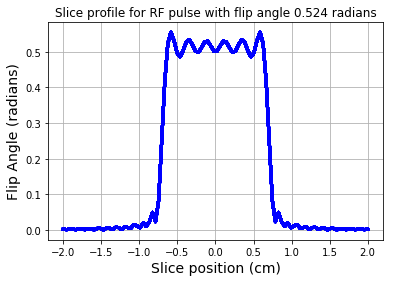

In [6]:
# Create vector of spatial positions in cm 
zt = np.linspace(-2,2,100)

# Convert the spatial position vector to a dimensionless normalized frequency vector to be used by SLR
z = np.multiply(zt,4.257 * G * T)

# Get the complex polynomials from forward SLR transform
# Gradient waveform scaled so that (gamma/2*pi)*sum(g) = k in cycles/cm: Assume constant gradient 
gVec = np.ones((np.shape(b1))) * 2 * np.pi / np.size(b1) 

# Compute the complex polynomials for the RF pulse
a,b = abrm(b1,gVec,z) 

# Compute the transver magnetization using these polynomials
mxy = ab2ex(a,b)

# Transverse magnetization gives the distribution of flip angles across the slice
fig = plt.figure(); plt.plot(zt,np.abs(mxy),'b-',linewidth=3.0)
plt.xlabel('Slice position (cm)',fontsize=14)
plt.ylabel('Flip Angle (radians)',fontsize=14)
plt.title('Slice profile for RF pulse with flip angle %1.3f radians' %theta)
plt.grid(True)
plt.show()

#### Effect of B1(t) on the longitudinal magnetization $M_z$. 

We can use the forward SLR transform to look at the longitudinal magnetization after a RF pulse. For the $30^o$ flip angle RF pulse the $M_z$ component looks like the plot below. Note that $M_z$ is not zero, due to the smaller tip angle. 

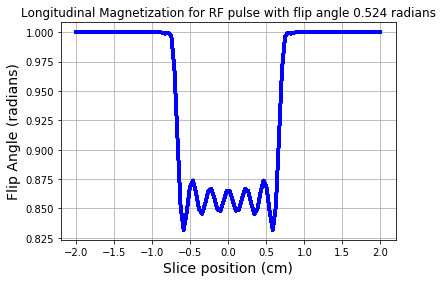

In [7]:
# Compute the longitudinal magnetization using these polynomials
mz = ab2inv(a,b)

fig = plt.figure(); plt.plot(zt,np.abs(mz),'b-',linewidth=3.0)
plt.xlabel('Slice position (cm)',fontsize=14)
plt.ylabel('Flip Angle (radians)',fontsize=14)
plt.title('Longitudinal Magnetization for RF pulse with flip angle %1.3f radians' %theta)
plt.grid(True)
plt.show()

#### If we had instead used a $90^o$ tip angle RF pulse, then the resultant longitudinal magnetization would be: 

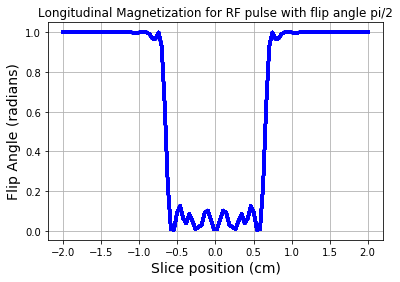

In [8]:
# Scale the RF to desired flip angle of 90 degree
b1_90 = (sinc / np.sum(sinc)) * np.pi/2
# Get the Mz component using forward SLR transform 
a_90,b_90 = abrm(b1_90,gVec,z) 
mz_90 = ab2inv(a_90,b_90)

fig = plt.figure(); plt.plot(zt,np.abs(mz_90),'b-',linewidth=3.0)
plt.xlabel('Slice position (cm)',fontsize=14)
plt.ylabel('Flip Angle (radians)',fontsize=14)
plt.title('Longitudinal Magnetization for RF pulse with flip angle pi/2')
plt.grid(True)
plt.show()


#### Q2: Slice Profile  
* What is the excited slice width ? How does this compare to the theoretical slice thickness
* We can observe some variations in the flip angle in the passband of the slice profile. However, the mean flip angle seems to be close to the desired value of $\pi/6$ radians. How does the slice profile change for the different time-bandwidth product pulses from Q1 ?  
* How does the excited slice profile change with change in slice gradient strength ($G$) ? 

### Windowed Sinc RF pulse Design

Recall that can use a window function to provide a smooth transition of the slice profile into the stopband. A windowed sinc pulse is defined as 

$
b1(t)= \left\{
                \begin{array}{ll}
                  A [(1-\alpha) + \alpha cos(\pi \frac{\Delta f}{N} (t - T/2))] sinc(\pi \Delta f (t-T/2)), if 0 \leq t \leq T/2\\
                  0, otherwise 
                \end{array}
              \right.
$

where, $N$ is the number of zero-crossings on one side of the sinc main lobe. 

Hamming window: if $\alpha = 0.46$ 
Hanning window: if $\alpha = 0.5$

#### Modify the sinc RF pulse from the previous module to design a Hamming window Sinc and plot its slice profile

* Use the same RF pulse parameters: TBW = 4, T = 4ms, and $\theta = 30$
* For the slice profile simulation assume G = 0.5 G/cm

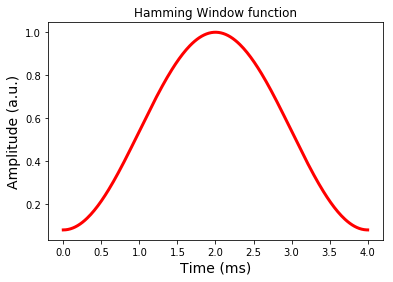

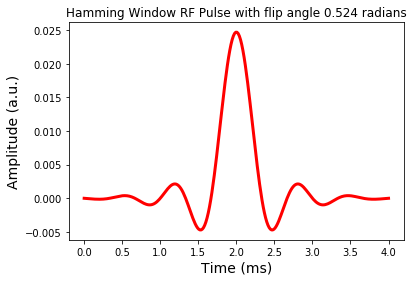

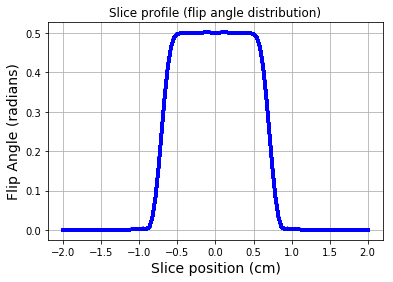

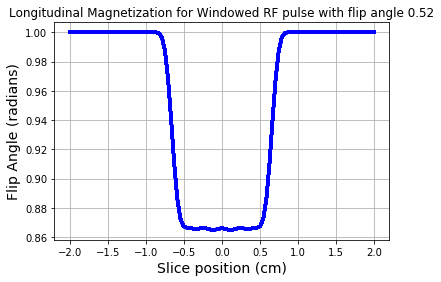

In [9]:
# Define the Hamming window  
alpha = 0.46
wind = (1-alpha) + (alpha * np.cos(np.pi * (bw/(tbw/2))*(t - T/2) ))

# Plot the RF
fig = plt.figure(); plt.plot(t,wind,'r-',linewidth=3.0)
plt.xlabel('Time (ms)',fontsize=14)
plt.ylabel('Amplitude (a.u.)',fontsize=14)
plt.title('Hamming Window function')
plt.show()

# Create Window sinc function
sincW = wind * sinc

# Scale the RF to desired flip angle
b1W = sincW / np.sum(sincW)
b1W = b1W * theta

# Plot the RF
fig = plt.figure(); plt.plot(t,b1W,'r-',linewidth=3.0)
plt.xlabel('Time (ms)',fontsize=14)
plt.ylabel('Amplitude (a.u.)',fontsize=14)
plt.title('Hamming Window RF Pulse with flip angle %1.3f radians' %theta)
plt.show()

# Compute the complex polynomials for the Windowed RF pulse
aW,bW = abrm(b1W,gVec,z) 

# Compute the transver magnetization using these polynomials
mxyW = ab2ex(aW,bW)

# Transverse magnetization gives the distribution of flip angles across the slice
fig = plt.figure(); plt.plot(zt,np.abs(mxyW),'b-',linewidth=3.0)
plt.xlabel('Slice position (cm)',fontsize=14)
plt.ylabel('Flip Angle (radians)',fontsize=14)
plt.title('Slice profile (flip angle distribution)')
plt.grid(True)
plt.show()

mzW = ab2inv(aW,bW)

fig = plt.figure(); plt.plot(zt,np.abs(mzW),'b-',linewidth=3.0)
plt.xlabel('Slice position (cm)',fontsize=14)
plt.ylabel('Flip Angle (radians)',fontsize=14)
plt.title('Longitudinal Magnetization for Windowed RF pulse with flip angle %1.2f' %theta)
plt.grid(True)
plt.show()


#### Q3: Window functions 

* Create a Hanning window Sinc RF pulse (using $\alpha = 0.5$) using the same pulse and gradient parameters. 
* How does the slice profile look ? Which window function would you prefer and why ? 

### Multi-band RF pulse Design 

We can simultaneously excite multiple slices by adding a phase to the RF pulse. This would introduce a shift in the slice profile. 

##### Hadamard encoding 
REF: S. P. Souza, J. Szumowski, C. L. Dumoulin, D. P. Plewes, G. Glover, SIMA: simultaneous multislice acquisition of MR images by Hadamard-encoded excitation. J Comput Assist Tomogr. 1988 Nov-Dec; 12(6): 1026–1030 

One approach to simultaneous multi-slice excitation is modulating the RF pulse separately by a sin() and a cos() function. 

$
rf1(t) = sinc(\pi \Delta f t) cos(\rho t) \\ 
rf2(t) = - sinc(\pi \Delta f t) sin(\rho t) 
$

where $\rho = 2*pi*\gamma*G_z* z_0$ is the slice offset frequency and $z_0$ is slice shift

Each RF pulse excites two slices simultaneously, however the slice profiles have different phase. 

By adding and subtracting the slice profiles from the two RF pulses, we can get the individual slices.  


#### Modulate the windowed sinc pulse previously designed by sin( ) and cos( ) functions and plot their slice profiles. 

* Let us assume a slice position offset of 5 cm from the isocenter. 

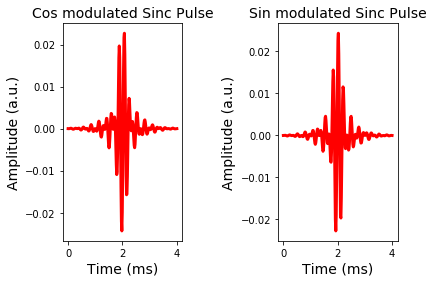

In [10]:
# Two slice multi-band excitation using Hadamard encoding 
mbFactor = 2
z0 = 5 # cm shift in slice position from iso-center
amplitudeScaling = 1 # scaling factor for B1(t) to ensure desired flip angle

# Modulate the RF pulse by a complex exponential and take the real and imaginary parts 
sinc_exp = amplitudeScaling * b1W * np.exp(-1j*2*np.pi*4.257*G/mbFactor*z0*t)
rf1 = np.real(sinc_exp)
rf2 = np.imag(sinc_exp)

# Plot the RF
fig = plt.figure(); 
plt.subplot(1,2,1)
plt.subplots_adjust(hspace=0.8,wspace=0.8)
plt.plot(t,rf1,'r-',linewidth=3.0)
plt.xlabel('Time (ms)',fontsize=14)
plt.ylabel('Amplitude (a.u.)',fontsize=14)
plt.title('Cos modulated Sinc Pulse',fontsize=14)
plt.subplot(1,2,2)
plt.plot(t,rf2,'r-',linewidth=3.0)
plt.xlabel('Time (ms)',fontsize=14)
plt.ylabel('Amplitude (a.u.)',fontsize=14)
plt.title('Sin modulated Sinc Pulse',fontsize=14)
plt.show()


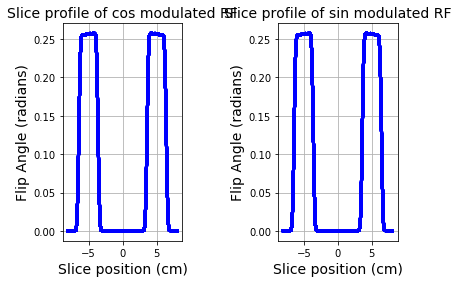

In [11]:
# Compute the individual slice profiles for the two RF pulses
zt1 = np.linspace(-8,8,100)
z1 = np.multiply(zt1,4.257 * G/mbFactor * T)

a1,b1 = abrm(rf1,gVec,z1) 
mxy1 = ab2ex(a1,b1)
a2,b2 = abrm(rf2,gVec,z1) 
mxy2 = ab2ex(a2,b2)

fig = plt.figure(); 
plt.subplot(1,2,1)
plt.subplots_adjust(hspace=0.8,wspace=0.8)
plt.plot(zt1,np.abs(mxy1),'b-',linewidth=3.0)
plt.xlabel('Slice position (cm)',fontsize=14)
plt.ylabel('Flip Angle (radians)',fontsize=14)
plt.title('Slice profile of cos modulated RF',fontsize=14)
plt.grid(True)
plt.subplot(1,2,2)
plt.plot(zt1,np.abs(mxy2),'b-',linewidth=3.0)
plt.xlabel('Slice position (cm)',fontsize=14)
plt.ylabel('Flip Angle (radians)',fontsize=14)
plt.title('Slice profile of sin modulated RF',fontsize=14)
plt.grid(True)
plt.show()

#### Decoding slices acquired using Hadamard RF encoding 

When pulse sequences use Hadamard encoding, two sets of acquisitons are performed using RF1 and RF2. The cos modulated RF excites the two slices in phase, while the sin modulated RF produces out of phase excitation. 

The code below shows how the encoded slices look for a 2 slice Hadamard encoding for cardiac imaging. 

The individual slices can be recovered by performing an inverse Hadamard transform; 
    * add and subtract the two encodes to decode the individual slices
    * scale the decoded images appropriately

Data dimensions:  (182, 192, 2)


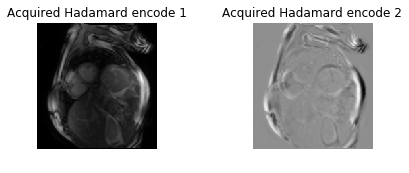

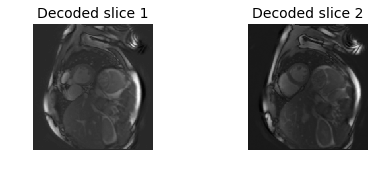

In [12]:
# Load Hadamard encoded cardiac data
from scipy import io
data = (io.loadmat('./data/hadamard_encodes.mat'))
encode = np.array(data['encodeH'])
print('Data dimensions: ', np.shape(encode))

# Display the two encode 
fig = plt.figure(); 
plt.subplot(1,2,1)
plt.subplots_adjust(hspace=0.8,wspace=0.8)
plt.imshow(np.rot90(encode[:,:,0]),cmap="gray", interpolation="none")
plt.title('Acquired Hadamard encode 1')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(np.rot90(encode[:,:,1]),cmap="gray", interpolation="none")
plt.title('Acquired Hadamard encode 2')
plt.axis('off')
plt.show()

# Perform Hadamard decoding 
slc = np.zeros(np.shape(encode))
slc[:,:,0] = (1/np.sqrt(2)) * encode[:,:,0] + encode[:,:,1]
slc[:,:,1] = (1/np.sqrt(2)) * encode[:,:,0] - encode[:,:,1]

# Display the two acquired slices
fig = plt.figure(); 
plt.subplot(1,2,1)
plt.subplots_adjust(hspace=0.8,wspace=0.8)
plt.imshow(np.rot90(slc[:,:,0]),cmap="gray", interpolation="none")
plt.title('Decoded slice 1',fontsize=14)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(np.rot90(slc[:,:,1]),cmap="gray", interpolation="none")
plt.title('Decoded slice 2',fontsize=14)
plt.axis('off')
plt.show()
